# Modelling a CANDU Bundle

In this example I will create a typical CANDU bundle with rings of fuel pins.
Since OpenMC does not have a specialized lattice for this type of arrangement, we have to create it manually using universes.

The code is developed using the Git Project concernig CANDU bundles provided by OpenMC  ([Example Jupyter Notebooks](https://github.com/openmc-dev/openmc/wiki/Example-Jupyter-Notebooks)) as example!

In [1]:
import matplotlib.pyplot as plt
from math import pi, sin, cos
import numpy as np
import openmc

In [2]:
# MATERIALS
# CANDU type reactors use UO2 fuel with heavy-water as coolant moderator
# since fuel is not enriched

#Fuel
fuel = openmc.Material(name='Uranium Dioxide')
fuel.add_element('U', 1.0)
fuel.add_element('O', 2.0)
fuel.set_density('g/cm3', 10.0)

#Cladding Zircaloy
clad = openmc.Material(name='Zircaloy')
clad.add_element('Zr', 1.0)
clad.set_density('g/cm3', 6.0)

#Heavy Water Coolant
coolant = openmc.Material(name='Heavy Water')
coolant.add_nuclide('H2', 2.0)
coolant.add_nuclide('O16', 1.0)
coolant.set_density('g/cm3', 1.1)

#Material Export Files
materials = openmc.Materials([fuel, clad, coolant])
materials.export_to_xml()

In [3]:
# GEOMETRY
# we have a series of 1, 6, 12, 18 fuel rods placed in three annular circles
# Outside of this structure the pressure tube wall separate the inner region
# from the outer Calandria tube

# Fuel Rod
r_fuel = 0.6122
r_clad = 0.6540

# Pressure Tube
pt_inner = 5.16890
pt_outer = 5.60320

# Calendria
cal_inner = 6.44780
cal_outer = 6.58750

# Radii for fuel rods centering - Boundary Surfaces
ring_radii = np.array([0.0, 1.4885, 2.8755, 4.3305]) # these represent the line where pin centers are located

The first step of geometry creation is the definition of the surfaces that constitute the various concentric circular crowns that identify the 'annular rows' of the bundle. We have to compute the min and max radii associated to each single crown and we build a universe made of cells, each of whom associated to the associated row. All cells are filled with water.

The second step is to build the Universe for the single fuel pin made up by a fuel surface and a cladding surface, and filled with fuel and cladding material. After having built these two Universes we will merge the together to fill the annular crowns with 1, 6, 12 and 18 fuel pin.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

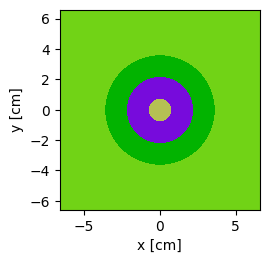

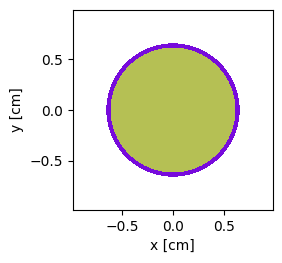

In [4]:
# Bundle Universe: Annular regions and Single Pin Universes

# we create surfaces that defines sectors where rods are arranged annularly
radial_surf = [openmc.ZCylinder(r=r) for r in
               (ring_radii[1:] + ring_radii[:-1])/2] # we are calculating the radial distances of annular sections that contain circular sections of fuel pins

# we use these surfaces to generate coolant cells
coolant_cells = []
for i in range(ring_radii.size):
    if i==0:
        cool_region = -radial_surf[i]
    elif i==ring_radii.size-1:
        cool_region = +radial_surf[i-1]
    else:
        cool_region = +radial_surf[i-1] & -radial_surf[i]

    coolant_cells.append(openmc.Cell(fill=coolant, region=cool_region))

# Plot or Different regions and center lines
annular_regions_univ = openmc.Universe(cells=coolant_cells)
plot_args = {'width': (2*cal_outer, 2*cal_outer)}

# We create the single fuel pin Universe made by fuel and cladding (without gap)
fuel_surf = openmc.ZCylinder(r=r_fuel)
clad_surf = openmc.ZCylinder(r=r_clad)

fuel_cell = openmc.Cell(fill=fuel, region=-fuel_surf)
clad_cell = openmc.Cell(fill=clad, region=+fuel_surf & -clad_surf)

pin_univ = openmc.Universe(cells=[fuel_cell, clad_cell])

#Plotting of the separate Universes that will be merged together
annular_regions_univ.plot(width=(2*cal_outer, 2*cal_outer))
pin_univ.plot(width=(3*r_clad, 3*r_clad))

As explained above, we have to use a for loop to build annular regions filled with fuel pins. Coolant cells need regions where there are fuel pins to be removed to avoid overlapping of materials. The pin Cell is filled with the pin universe located within the herein defined pin boundary. To the previously Universe of annular crowns we add this new Cell containing all the fuel pins in position. The final Bundle Universe is constituted by annular crowns Universe with all the fuel pins in positions !!!

This Bundle Universe will fill the region within the pressure tube cell, that along with the calendria tube cell will constitute the Complete System Universe !!! We can then color by material !!!

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

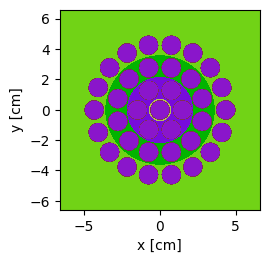

In [5]:
# Bundle Universe: Single Pins are ordered inside regions defined as annular regions

num_ring = [0, 1, 2, 3]
num_pin = [1, 6, 12, 18] # number of pins per annulus
angle = [0, 0, 15, 0] # 2dnd ring is rotate a bit to maintain symmetry

# for each indiex assigned to a tuple of radius, pin number and rotational angle:
for i, (r, n, a) in enumerate(zip(ring_radii, num_pin, angle)):
    for j in range(n):
        #Center of each single pin
        teta = (a + (j/n)*360.0) * pi/180.0
        x = r*cos(teta) #cartesian coordinate
        y = r*sin(teta) #cartesian coordinate

        #Boundary to define where we have to locate the pin_univ created!!!
        pin_boundary = openmc.ZCylinder(x0=x, y0=y, r=r_clad)

        #coolant_cells must be modified to exclude portions of space where pins are located, therefore:
        coolant_cells[i].region &= +pin_boundary # to each single coolant cell we are removing coolant to avoid overlapping

        pin = openmc.Cell(fill=pin_univ, region=-pin_boundary)
        pin.translation = (x, y, 0)
        pin.id = (i+1)*100 + j #to identify each single pin
        #We add pin Universe to the annular region of water, where coolant cells are modified
        bundle_universe = annular_regions_univ
        bundle_universe.add_cell(pin)

#Plotting of the separate Universes that will be merged together
bundle_universe.plot(width=(2*cal_outer, 2*cal_outer))

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

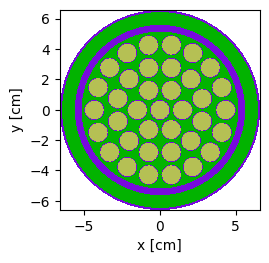

In [6]:
# Calendria + Pressure Tube + Assembly Universe !!!
# now we can create the pressure tube Cell and the Calendria Cell and fill the with the Universe
# generated for the bundle of annularly located pins

#Regions
pt_inner_region = openmc.ZCylinder(r=pt_inner)
pt_outer_region = openmc.ZCylinder(r=pt_outer)
cal_inner_region = openmc.ZCylinder(r=cal_inner)
cal_outer_region = openmc.ZCylinder(r=cal_outer, boundary_type='vacuum')

#Cells
bundle_cell = openmc.Cell(fill=bundle_universe, region=-pt_inner_region)
pressure_tube_cell = openmc.Cell(fill=clad, region=-pt_outer_region & +pt_inner_region)
coolant_flow_cell = openmc.Cell(fill=coolant, region=+pt_outer_region & -cal_inner_region)
calendria_cell = openmc.Cell(fill=clad, region=-cal_outer_region & +cal_inner_region)

#Complete Universe - Root Universe
system_universe = openmc.Universe(cells=(bundle_cell, pressure_tube_cell, coolant_flow_cell, calendria_cell))
system_universe.plot(width=(2*cal_outer, 2*cal_outer), color_by='material')

In [7]:
#PLOTTING the whole geometry with plot_inline: we require the export files
geometry = openmc.Geometry(system_universe)
geometry.export_to_xml()

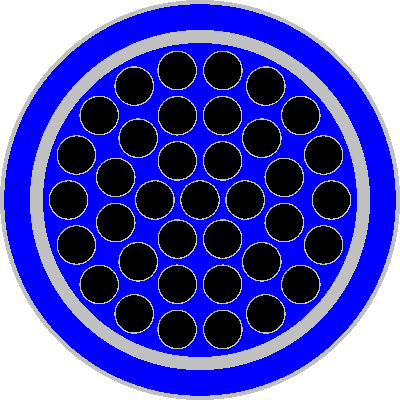

In [8]:
plot1 = openmc.Plot.from_geometry(geometry)
plot1.basis = 'xy'
plot1.origin = (0,0,0)
plot1.width = (2*cal_outer, 2*cal_outer)
plot1.color_by = 'material'
plot1.colors = {fuel: 'black', clad:'silver', coolant:'blue'}

plots = openmc.Plots([plot1])
openmc.plot_inline(plots)

**Source and Settings definition**

We have now to set the source properly by considering the region of interest. Only fissionable nuclides are considered for the simulation.
Settings require active and inactive cycles, and number of neutrons used for the simulation.

In [9]:
#SETTINGS and SOURCE

source_volume = openmc.stats.Box([-cal_outer, -cal_outer, 0], [cal_outer, cal_outer, 0], only_fissionable=True)
source = openmc.Source(space=source_volume)
source.angle = openmc.stats.Isotropic()

settings = openmc.Settings()
settings.source = source
settings.batches = 20
settings.inactive = 5
settings.particles = 20000
settings.export_to_xml()

/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


**Mesh and Tally definition**

I am interested in a spatial mesh only (no filter in energy for this case). After having defined the mesh filter, this one is used as filter for the Tally. Tallies require a *filter* (energy / space) and a *score* (the quantity that we want to analyze). In this case both *flux* and *fission events* are studied.

In [10]:
mesh1=openmc.RegularMesh()
mesh1.dimension =  [400,400,1]
mesh1.lower_left = [-cal_outer, -cal_outer, -1]
mesh1.upper_right = [cal_outer, cal_outer, 1]
mesh1_filter = openmc.MeshFilter(mesh1)

t1 = openmc.Tally(name='flux1')
t1.filters =[mesh1_filter]
t1.scores = ['flux','fission']

tallies=openmc.Tallies([t1])
tallies.export_to_xml()

In [11]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [13]:
#SatePoint Extraction Process

sp = openmc.StatePoint('statepoint.20.h5')

tl = sp.get_tally(name='flux1')
flux1 = tl.get_slice(scores=['flux'])
flux2 = tl.get_slice(scores=['fission'])
                     
flux1.mean.shape=(400,400)
flux2.mean.shape=(400,400)

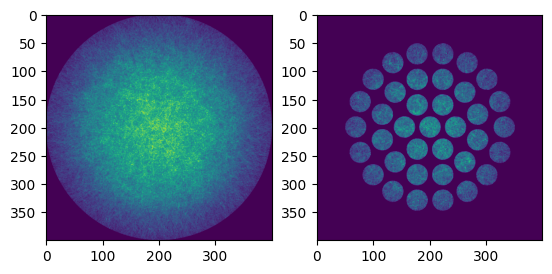

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)

im1 = ax1.imshow(flux1.mean)
im2 = ax2.imshow(flux2.mean)